<a href="https://colab.research.google.com/github/matjesg/deepflash2/blob/master/paper/benchmark_cellpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - cellpose benchmark

> This notebook reproduces the *cellpose* results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693) for instance segmentation.

- **Data**: The data is available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.

- **Models**: The trained models are also available on [Google Drive](https://drive.google.com/drive/folders/1BZRrRTDuJw5EoBqz1RWoFKZ7eq2kEwxm?usp=sharing). To use the trained models for prediction, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.


*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

Stringer, C., Wang, T., Michaelos, M., & Pachitariu, M. (2021). Cellpose: a generalist algorithm for cellular segmentation. Nature Methods, 18(1), 100-106.


## Setup

- Install dependecies
- Connect to drive

In [ ]:
!pip install fastcore opencv-python-headless==4.5.4.60
!pip install git+https://github.com/MouseLand/cellpose.git@316927eff7ad2201391957909a2114c68baee309

In [2]:
# Imports
import numpy as np
import tifffile
import imageio
import cv2
import os
from sklearn.model_selection import KFold
from pathlib import Path
from cellpose import models, dynamics
from fastcore.foundation import L
from skimage.color import label2rgb
import matplotlib.pyplot as plt

2022-02-02 15:22:57,076 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log


In [ ]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

## Settings

Choose dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`, `GFAP_in_HC`
- Instance segmentation does not work properly on `GFAP_in_HC` due to overlapping instances; we only include this data set for completeness.



In [4]:
DATASET = 'cFOS_in_HC'
SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
PREPROC_PATH = Path("/content/data")
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/benchmark_models/cellpose/')
path = DATA_PATH/DATASET

pretrained_dict = {
    'PV_in_HC':'cyto', 
    'cFOS_in_HC':'cyto2',
    'mScarlet_in_PAG':'cyto2',
    'YFP_in_CTX':'cyto',
    'GFAP_in_HC':'cyto2'
}

diam_dict = {
    'PV_in_HC':24, 
    'cFOS_in_HC':15, 
    'mScarlet_in_PAG':55, 
    'YFP_in_CTX':50,
    'GFAP_in_HC':17
}

mean_diam_dict = {
    'PV_in_HC':30, 
    'cFOS_in_HC':17, 
    'mScarlet_in_PAG':17,
    'YFP_in_CTX':30,
    'GFAP_in_HC':17,
}

# cellpose settings
channels=[0,0]
use_GPU = True
device = models.assign_device(True, use_GPU)

2022-02-02 15:23:19,173 [INFO] ** TORCH CUDA version installed and working. **
2022-02-02 15:23:19,177 [INFO] >>>> using GPU


## Data preprocessing

- cellpose training cannot handle images with a greater width than height, thus we cut all training images into squares
- preprocessing for flow represenations

In [ ]:
train_image_path = path/'train'/'images'
train_masks_path = path/'train'/'masks_STAPLE'

train_preproc_path = PREPROC_PATH/DATASET/f'train'
train_preproc_path.mkdir(exist_ok=True, parents=True)

train_images = [x for x in train_image_path.iterdir() if not x.name.startswith('.')]
label_fn = lambda x: train_masks_path/f'{x.name[:-4]}_mask.png'

for f in train_images:

    # images
    img = imageio.imread(f)
    shape_orig = img.shape
    min_shape = min(img.shape)
    img = img[:min_shape,:min_shape]
    print(f, shape_orig, img.shape)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_img.tif', img, compress=6)

    # masks
    msk = imageio.imread(label_fn(f))
    # These labels can be noisy due to the ground truth estimation procedure (STAPLE)
    _, label_msk = cv2.connectedComponents(msk.astype('uint8'), connectivity=4)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_masks.tif', label_msk, compress=6)

## Train models

- Adapted from cellpose train [script](https://github.com/MouseLand/cellpose/blob/master/cellpose/__main__.py)
- You can skip this step use the trained models from our paper (see next section).

In [ ]:
kf = KFold(5, shuffle=True, random_state=SEED)

pretrained_model = pretrained_dict[DATASET]
print('pretrained_model', pretrained_model)

if pretrained_model=='cyto':
    szmean = 30.
else:
    szmean = 17.

images = L(sorted([x for x in train_preproc_path.iterdir() if x.name.endswith('img.tif')]))

for train_index, test_index in kf.split(images):
    img_train, img_val = images[train_index], images[test_index]
    print('Train', len(img_train), 'val', len(img_val))
    print(img_val)

    train_data = list(tifffile.imread(img_train))
    train_labels = tifffile.imread([train_preproc_path/f'{f.stem[:-4]}_masks.tif' for f in img_train])
    train_labels= list(train_labels)
    train_files = [f.stem for f in img_train]

    test_data = list(tifffile.imread(img_val))
    test_labels = tifffile.imread([train_preproc_path/f'{f.stem[:-4]}_masks.tif' for f in img_val])
    test_labels= list(test_labels)
    test_files = [f.stem for f in img_val]

    cpmodel_path = models.model_path(pretrained_model, 0, True)

    model = models.CellposeModel(gpu=use_GPU,
                                 pretrained_model=cpmodel_path, 
                                 diam_mean=szmean,
                                 nchan=2)

    cpmodel_path = model.train(train_data,
                                train_labels,
                                train_files=img_train,
                                test_data=test_data,
                                test_labels=test_labels,
                                test_files=img_val,
                                channels=channels,
                                save_path=(MODEL_PATH/DATASET/f'{SEED}').as_posix(),
                                rescale=True,
                                n_epochs=500
                              )

## Prediction on test set

We will use the following models
- *cellpose*: pretrained cellpose models
- *cellpose ensemble*: fine-tuned cellpose ensemble (see Training)
- *cellpose single*: fine-tuned cellpose single model as the first model of ensemble

Labels are converted and saved to
- Semantic segmentation masks (.png)
- Instance segmentation masks (.tif) using the connected components algorithm

To ensure reproducibilty we will use the fine-tuned models from our paper!

Using fine tuned model
['/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_19_47.258893', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_30_24.311944', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_41_35.762615', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_16_02_45.984039', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_52_08.134336']
2022-02-02 15:23:21,656 [INFO] parsing model string cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_19_47.258893 to get cellpose options
2022-02-02 15:23:21,663 [INFO] ** TORCH CUDA version installed and working. **
2022-02-02 15:23:21,665 [INFO] >>>

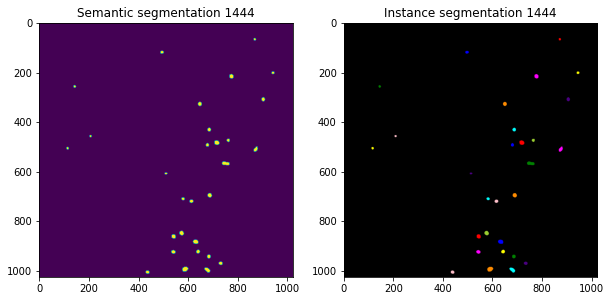

1385.tif


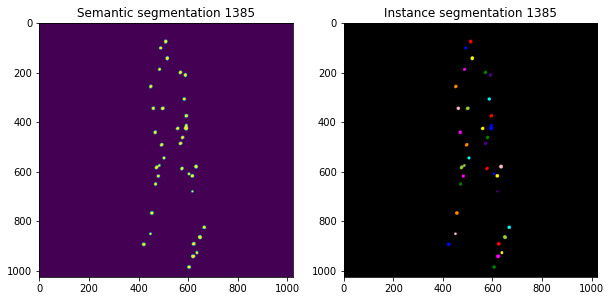

1418.tif


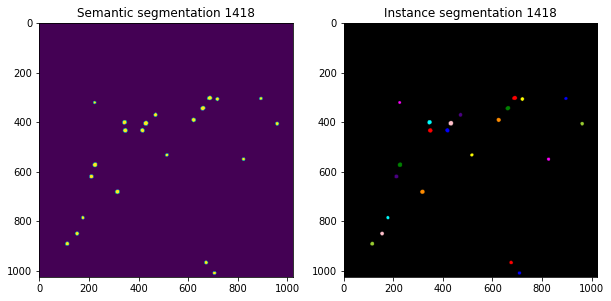

1582.tif


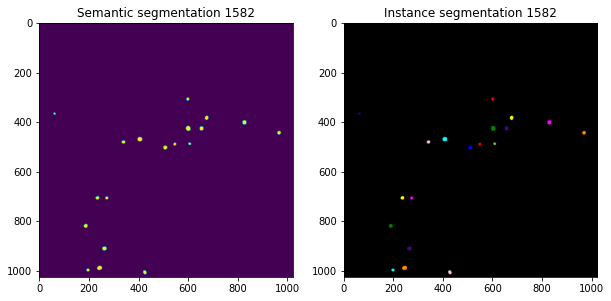

1377.tif


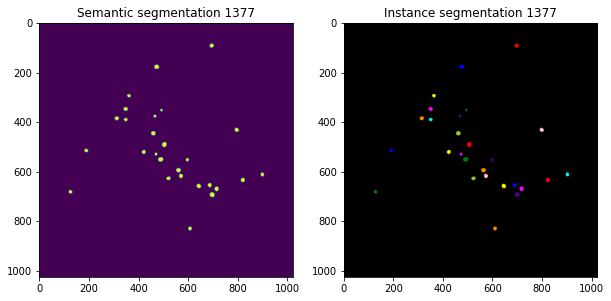

1283.tif


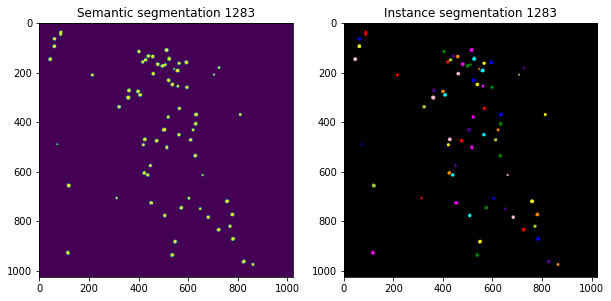

1599.tif


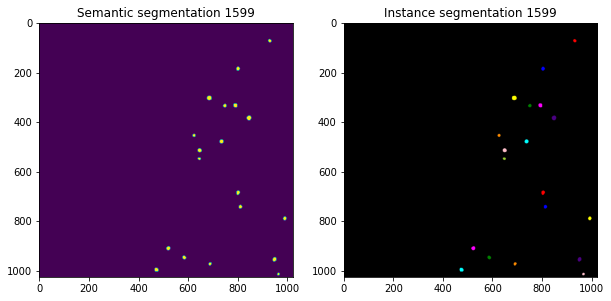

1237.tif


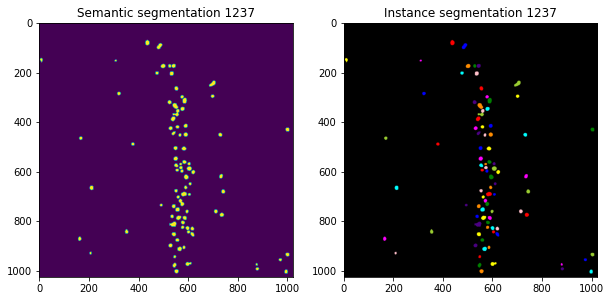

Using fine tuned model
['/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_19_47.258893']
2022-02-02 15:24:11,598 [INFO] parsing model string cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_19_47.258893 to get cellpose options
2022-02-02 15:24:11,601 [INFO] ** TORCH CUDA version installed and working. **
2022-02-02 15:24:11,604 [INFO] >>>> using GPU
2022-02-02 15:24:23,464 [INFO] 100%|##########| 8/8 [00:11<00:00,  1.46s/it]
1444.tif


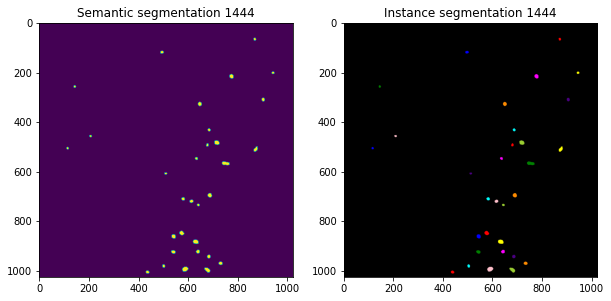

1385.tif


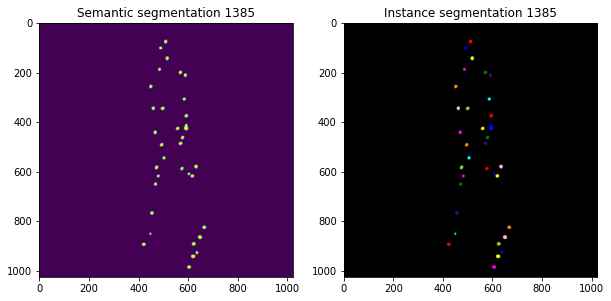

1418.tif


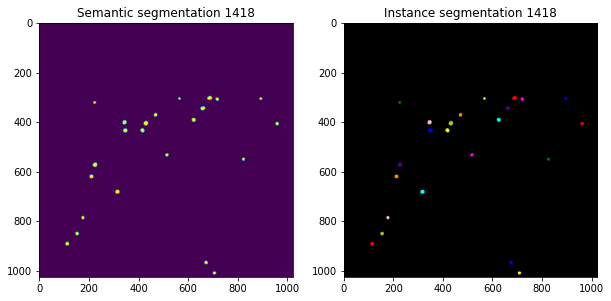

1582.tif


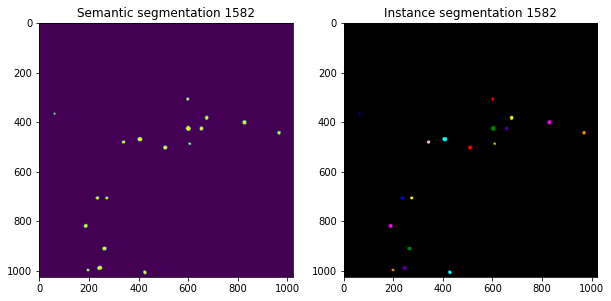

1377.tif


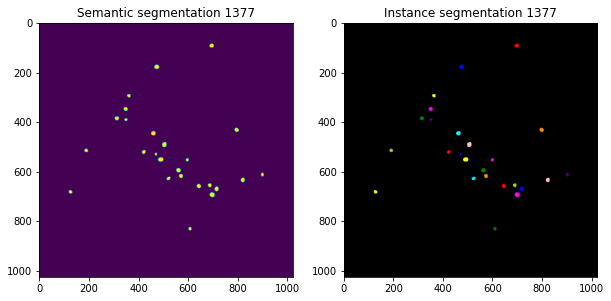

1283.tif


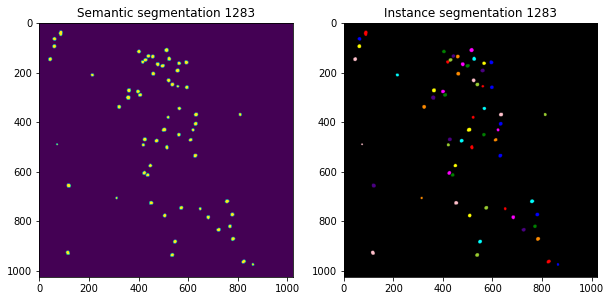

1599.tif


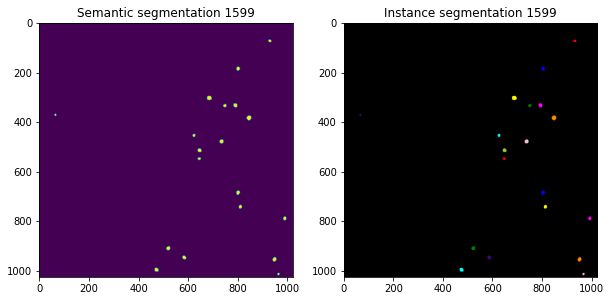

1237.tif


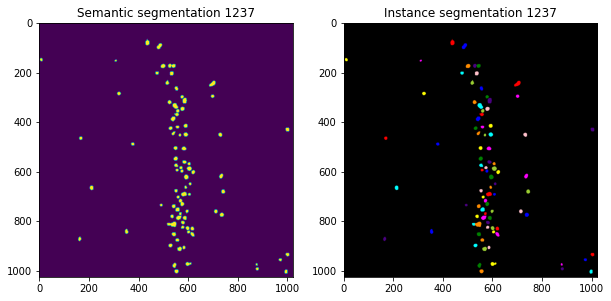

cellpose
2022-02-02 15:24:28,999 [INFO] ** TORCH CUDA version installed and working. **
2022-02-02 15:24:29,008 [INFO] >>>> using GPU
2022-02-02 15:24:29,089 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 15:25:51,642 [INFO] 100%|##########| 8/8 [01:22<00:00, 10.32s/it]
2022-02-02 15:25:51,653 [INFO] >>>> TOTAL TIME 82.56 sec
1444.tif


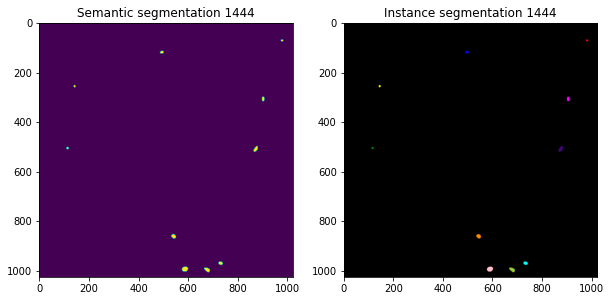

1385.tif


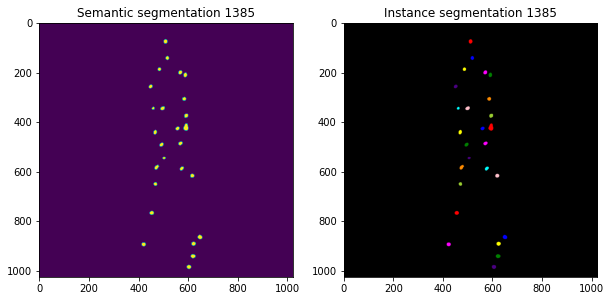

1418.tif


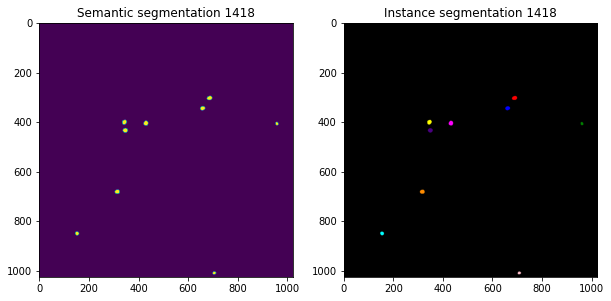

1582.tif


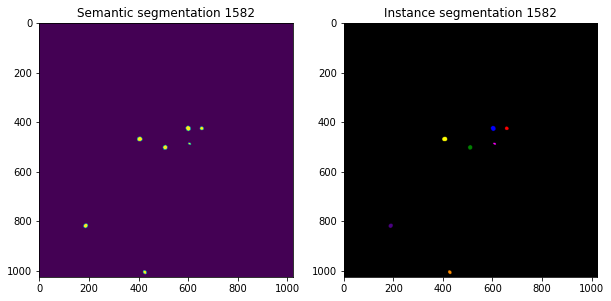

1377.tif


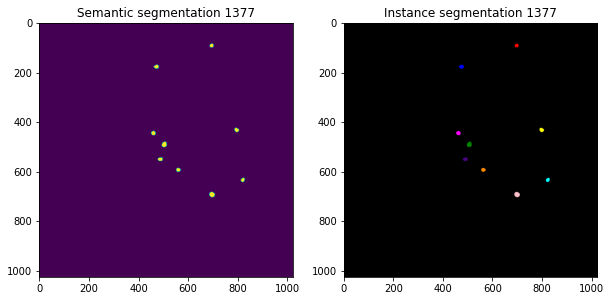

1283.tif


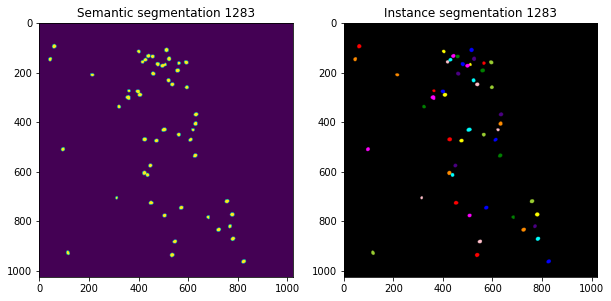

1599.tif


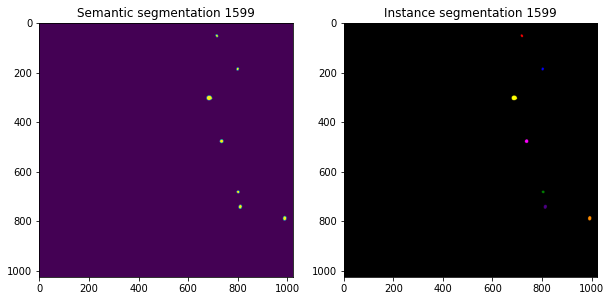

1237.tif


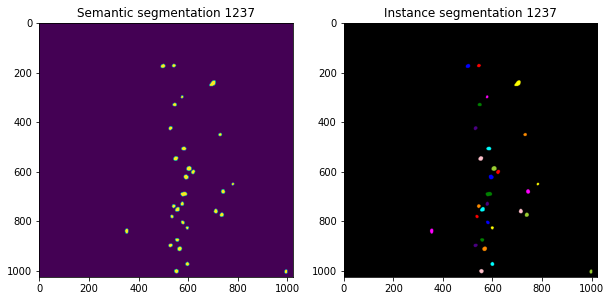

In [5]:
test_image_path = path/'test'/'images'
test_files = [x for x in test_image_path.iterdir() if not x.name.startswith('.')]
test_images = list(tifffile.imread(test_files))
    
for model_type in ['cellpose_ensemble', 'cellpose_single', 'cellpose']:

    if model_type=='cellpose':
        print(model_type)
        model_type2=pretrained_dict[DATASET]
        model = models.Cellpose(gpu=use_GPU, model_type=model_type2)

        masks, flows, styles, diams = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )

    else:
        print('Using fine tuned model')
        pretrained_models = [x.as_posix() for x in (TRAINED_MODEL_PATH/f'{SEED+1}'/DATASET/'models').iterdir() 
                             if not x.name.endswith('_size.npy') and not x.name.startswith('.')]
        if model_type=='cellpose_single': pretrained_models = pretrained_models[:1]
        print(pretrained_models)
        model = models.CellposeModel(gpu=use_GPU, 
                                     pretrained_model=pretrained_models,
                                     diam_mean=mean_diam_dict[DATASET], 
                                    )
        
        masks, flows, styles = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )


    
    prediction_path = OUTPUT_PATH/DATASET/model_type
    for i, f in enumerate(test_files):
        print(f.name)
        idx = f.stem
        label_msk = masks[i]
        # Save semantic segmentation prediction
        masks_path = prediction_path/'masks'
        masks_path.mkdir(parents=True, exist_ok=True)
        imageio.imwrite(masks_path/f'{idx}.png', ((label_msk>0)*255).astype('uint8'))

        # Save instance segmentation prediction
        instance_masks_path = prediction_path/'instance_masks'
        instance_masks_path.mkdir(exist_ok=True)
        tifffile.imwrite(instance_masks_path/f'{idx}.tif', label_msk.astype('int16'), compress=6)

        # Plot
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))
        axs[0].imshow(label_msk>0)
        axs[0].set_title(f'Semantic segmentation {idx}')
        axs[1].imshow(label2rgb(label_msk, bg_label=0))
        axs[1].set_title(f'Instance segmentation {idx}')
        plt.show()